# Tutorial 5a: Neural Posterior Estimation to infer parameters of an impacting subhalo from stellar streams
Credit: Tri Nguyen and Claude Code

## Overview

In this tutorial, we will demonstrate how to implement a Neural Posterior Estimation (NPE) model to infer the parameters of a dark matter subhalo that has impacted a stellar stream. This is a realistic astrophysics application of simulation-based inference (SBI), where we want to understand subhalo properties from observable stream morphology.

**Physical Context**: When a dark matter subhalo passes near a stellar stream, it perturbs the positions and velocities of the stream stars. The pattern of this perturbation encodes information about the subhalo's mass and velocity. By training an NPE model on simulated stream-subhalo encounters, we can infer the subhalo properties from observations.

**What we'll cover:**
- Loading and visualizing simulated stellar stream data with subhalo impacts
- Preparing training data for NPE with proper normalization
- Training a simple NPE model (MLP embedding + Neural Spline Flow)
- Validating the model with coverage tests (rank-based and TARP)

In [1]:
# Import libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Loading the Simulation Data

We will first load the stream data from the `data` directory. The data contains 10,000 simulated stellar streams, each with a different subhalo impact scenario. The streams are generated using the `StreamSculptor` package [Nibauer et al. (2024)](https://arxiv.org/abs/2410.21174v1).

**Data Structure:**
- `params_dict`: A dictionary containing the simulation parameters for each stream:
  - `M_sh`: Subhalo mass in solar masses ($\mathrm{M_\odot}$). Shape: `(10000,)`
  - `vz_impact`: Impact velocity in the $z$ direction (line-of-sight) in km/s. Shape: `(10000,)`
- `streams`: The 6D phase-space coordinates of stream stars: $(x, y, z, v_x, v_y, v_z)$
  - Shape: `(10000, N_stars, 6)` where `N_stars = 9998` for all streams in this dataset
  
**Physical Interpretation**: Each stream represents a tidal disruption event that has been perturbed by a passing subhalo. The subhalo mass determines the strength of the perturbation, while the impact velocity affects the timescale and spatial pattern of the disturbance.

In [2]:
with open('data/data_small.pkl', 'rb') as f:
    data = pickle.load(f)
params_dict = data['params_dict']
streams = data['streams']  # shape: (N_samples, N_particles, 6) # 6 corresponds to (x, y, z, vx, vy, vz)

# params_dict contain two columns: M_sh (the subhalo mass) and vz_impact (the impact velocity along the line of sight)
M_sh = params_dict['M_sh']
vz_impact = params_dict['vz_impact']

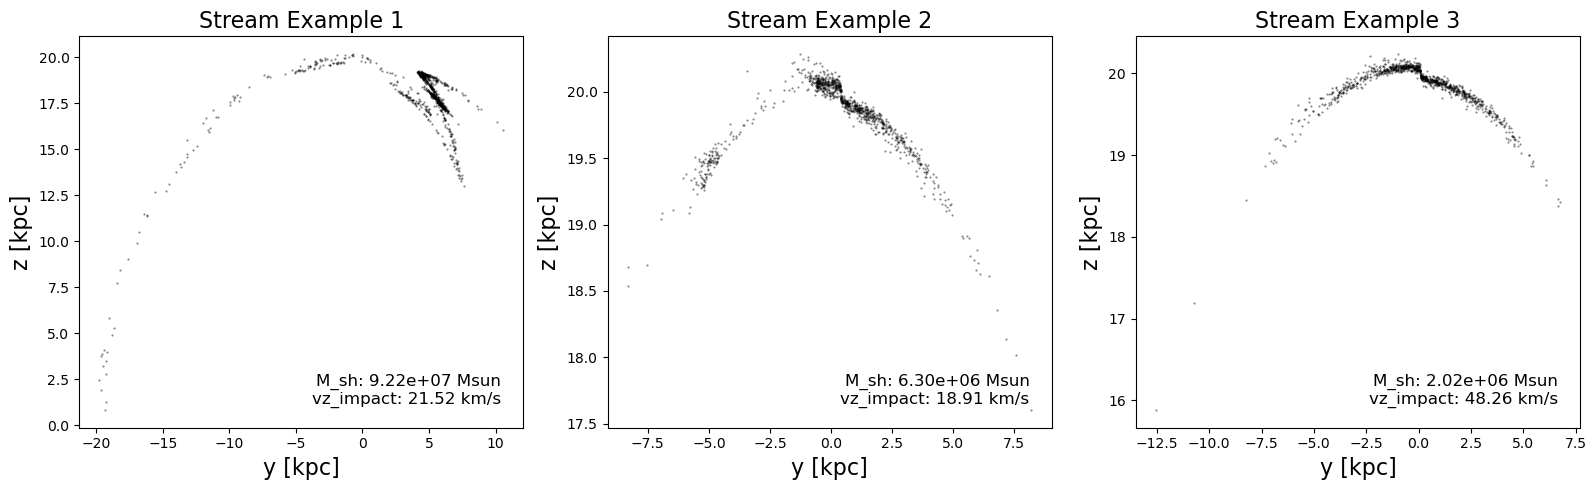

In [3]:
# Figure 1: Plot a few example streams to visualize the data distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, ax in enumerate(axes):
    ax.plot(streams[i, :, 1], streams[i, :, 2], 'k.', markersize=1, alpha=0.5)
    ax.set_title(f'Stream Example {i+1}', fontsize=16)
    ax.set_xlabel('y [kpc]', fontsize=16)
    ax.set_ylabel('z [kpc]', fontsize=16)

    # print some info about the stream
    text = f'M_sh: {M_sh[i]:.2e} Msun\nvz_impact: {vz_impact[i]:.2f} km/s'
    ax.text(0.95, 0.05, text, transform=ax.transAxes, fontsize=12,
            va='bottom', ha='right')

plt.tight_layout()
plt.show()

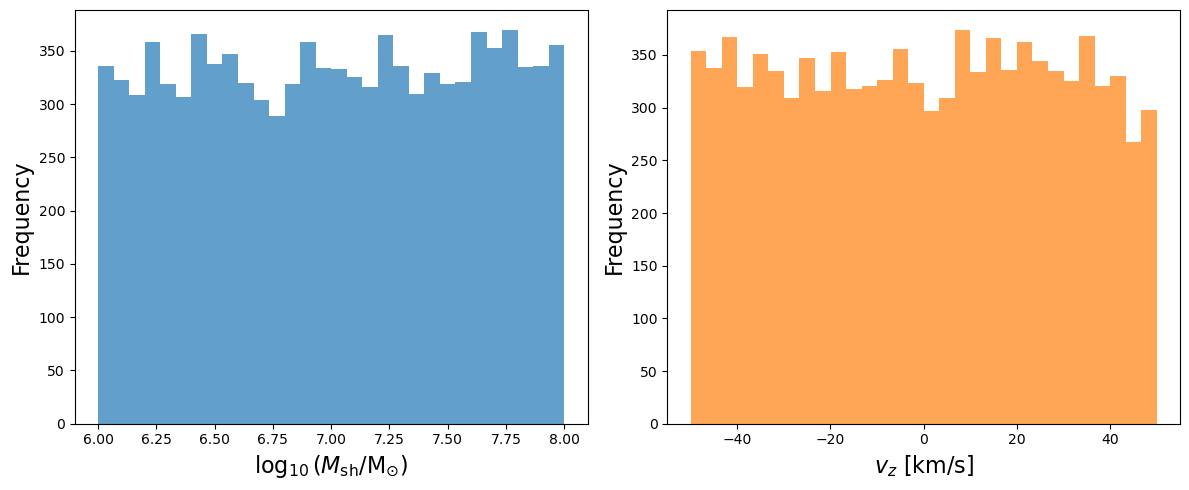

In [4]:
# Figure 2: Plot the distribution of the two parameters to visualize the prior distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(np.log10(M_sh), bins=30, color='C0', alpha=0.7)
axes[0].set_xlabel(r'$\log_{10}(M_\mathrm{sh}/\mathrm{M}_{\odot})$', fontsize=16)
axes[0].set_ylabel('Frequency', fontsize=16)

axes[1].hist(vz_impact, bins=30, color='C1', alpha=0.7)
axes[1].set_xlabel('$v_{z}$ [km/s]', fontsize=16)
axes[1].set_ylabel('Frequency', fontsize=16)

plt.tight_layout()
plt.show()

## Prior Distributions

From the histograms above, we can see that the parameters are sampled from the following distributions:

- $\log_{10} (M_\mathrm{sh} / \mathrm{M_\odot}) \sim \mathcal{U}(6, 8)$
- $v_{z} \sim \mathcal{U}(-50, 50) \, \mathrm{km/s}$

where $\mathcal{U}(a, b)$ denotes a uniform distribution between $a$ and $b$. 

**IMPORTANT**: In NPE, the distributions of parameters in the training dataset effectively define the **prior distributions** $p(\theta)$. The trained model will learn the posterior $p(\theta|x)$ based on these priors.

## Simple NPE: MLP embedding + NSF

We will implement a simple NPE model with a Multi-Layer Perceptron (MLP) embedding network and a Neural Spline Flow (NSF) density estimator. In the subsequent tutorial, we will explore more advanced architectures.

## 1. Preparing the Data

We first prepare the data for the SimpleNPE model. The MLP embedding network takes input of shape `(N_batch, N_features)`, so we need to flatten the stream data from shape `(N_samples, N_stars, 6)` to `(N_samples, N_stars * 6)`.

**Key preprocessing steps:**

1. **Flattening**: Convert 2D particle arrays to 1D feature vectors for MLP input

2. **Feature normalization**: Normalize all stream features (positions, velocities) to have zero mean and unit variance
   - This improves training stability and convergence speed
   - Prevents features with larger magnitudes from dominating the learning

3. **Parameter normalization**: Normalize parameters to the range $[-1, 1]$
   - Neural Spline Flows (NSF) are designed to work within a bounded region. This normalization is necessary, else the distributions will be unphysically truncated.
   - In `zuko`, this is set to $[-5, 5]$ by default, but normalizing to $[-1, 1]$ provides better numerical stability during training.

**Note**: We also subsample streams to 1000 particles (from 9998) to reduce computational cost.

In [5]:
def prepare_training_mlp(streams, params_dict, train_frac=0.8, batch_size=32):
    """ Prepare training data for MLP + NSF model """
    N_samples, N_particles, N_features = streams.shape
    streams = streams.reshape(N_samples, N_particles * N_features)  # Flatten the streams

    # note: in practice, it is better to train on log10(M_sh) instead of M_sh
    # because M_sh spans several orders of magnitude
    params = np.vstack((np.log10(params_dict['M_sh']), params_dict['vz_impact'])).T  # (N_samples, 2)

    # divide the training data into training and validation sets
    N_train = int(train_frac * N_samples)
    X_train = torch.tensor(streams[:N_train], dtype=torch.float32)
    y_train = torch.tensor(params[:N_train], dtype=torch.float32)
    X_val = torch.tensor(streams[N_train:], dtype=torch.float32)
    y_val = torch.tensor(params[N_train:], dtype=torch.float32)

    print('Number of training samples:', X_train.shape[0])
    print('Number of validation samples:', X_val.shape[0])

    # normalize the inpput and output features
    X_loc, X_scale = X_train.mean(0), X_train.std(0)
    y_min, y_max = y_train.min(0)[0], y_train.max(0)[0]
    y_loc = (y_min + y_max) / 2
    y_scale = (y_max - y_min) / 2
    X_train = (X_train - X_loc) / X_scale
    y_train = (y_train - y_loc) / y_scale
    X_val = (X_val - X_loc) / X_scale
    y_val = (y_val - y_loc) / y_scale

    # create DataLoader for training and validation sets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    norm_dict = {'X_loc': X_loc, 'X_scale': X_scale, 'y_loc': y_loc, 'y_scale': y_scale}

    return train_loader, val_loader, norm_dict

def subsample_streams(streams, N_particles_subsampled=100):
    """ Subsample the streams to a fixed number of particles """
    N_samples, N_particles, N_features = streams.shape
    if N_particles_subsampled >= N_particles:
        return streams  # no need to subsample

    streams_subsampled = np.zeros((N_samples, N_particles_subsampled, N_features))
    for i in range(N_samples):
        indices = np.random.choice(N_particles, N_particles_subsampled, replace=False)
        streams_subsampled[i] = streams[i, indices]

    return streams_subsampled

# subsample to reduce computational load
streams_subsampled = subsample_streams(streams, N_particles_subsampled=100)
train_loader, val_loader, norm_dict = prepare_training_mlp(
    streams_subsampled, params_dict, train_frac=0.9, batch_size=32)

Number of training samples: 9000
Number of validation samples: 1000


## 2. Create and Train the NPE Model

Now we'll create our NPE model and train it. The model consists of two main components:

1. **MLP Embedding Network**: Compresses the high-dimensional stream data (3000 features from 1000 particles × 3 positions) into a low-dimensional embedding (8 dimensions)
2. **Neural Spline Flow**: A normalizing flow that learns the conditional posterior distribution $p(\theta|x)$ given the embedding

**Training Details:**
- We use negative log-likelihood as the loss function (maximize $\log p(\theta|x)$)
- AdamW optimizer with weight decay for regularization
- Monitor both training and validation loss to detect overfitting

For more information on the NPE training procedure, please refer to Tutorial 1.

In [6]:
from models import simple_npe

In [7]:
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, device='cpu'):
    """
    Train the NPE model given training and validation data loaders.
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    device = torch.device(device)
    model.to(device)

    train_losses = []
    val_losses = []
    print(f"Training for {epochs} epochs...\n")

    for epoch in range(epochs):

        model.train()
        epoch_loss = 0.0
        n_batches = 0
        for x_batch, theta_batch in train_loader:
            optimizer.zero_grad()
            log_prob = model.log_prob(theta_batch.to(device), x_batch.to(device))
            loss = -log_prob.mean()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        train_losses.append(avg_loss)

        # compute the validation loss at the end of each epoch
        model.eval()
        val_epoch_loss = 0.0
        n_val_batches = 0
        with torch.no_grad():
            for x_val_batch, theta_val_batch in val_loader:
                val_log_prob = model.log_prob(theta_val_batch.to(device), x_val_batch.to(device))
                val_loss = -val_log_prob.mean()

                val_epoch_loss += val_loss.item()
                n_val_batches += 1
        val_avg_loss = val_epoch_loss / n_val_batches
        val_losses.append(val_avg_loss)

        # print progress every epoch
        print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_avg_loss:.4f}")

    print("\n✓ Training complete!")
    return train_losses, val_losses

In [8]:
simple_npe = simple_npe.SimpleNPE(
    input_dim=streams_subsampled.shape[1] * streams_subsampled.shape[2],  # (100 particles * 6 features)
    output_dim=2,
    hidden_size=32,
    embedding_size=8,
    transforms=6
)

# note: I set epoch to 20 to save time during testing, which I find sufficient for the model
# to converge. In practice, consider training for more epochs
train_losses, val_losses = train_model(
    simple_npe, train_loader, val_loader, epochs=20, lr=1e-4,
    device='cpu'
)

Training for 20 epochs...

Epoch   1/20 | Train Loss: 1.4318 | Val Loss: 0.8152
Epoch   2/20 | Train Loss: 0.5968 | Val Loss: 0.5535
Epoch   3/20 | Train Loss: 0.3740 | Val Loss: 0.3627
Epoch   4/20 | Train Loss: 0.2416 | Val Loss: 0.2511
Epoch   5/20 | Train Loss: 0.1407 | Val Loss: 0.1596
Epoch   6/20 | Train Loss: 0.0386 | Val Loss: 0.1024
Epoch   7/20 | Train Loss: -0.0598 | Val Loss: 0.0526
Epoch   8/20 | Train Loss: -0.1600 | Val Loss: -0.0480
Epoch   9/20 | Train Loss: -0.2522 | Val Loss: -0.1358
Epoch  10/20 | Train Loss: -0.3442 | Val Loss: -0.2046
Epoch  11/20 | Train Loss: -0.4281 | Val Loss: -0.2136
Epoch  12/20 | Train Loss: -0.4933 | Val Loss: -0.2516
Epoch  13/20 | Train Loss: -0.5470 | Val Loss: -0.2799
Epoch  14/20 | Train Loss: -0.6091 | Val Loss: -0.3688
Epoch  15/20 | Train Loss: -0.6695 | Val Loss: -0.2742
Epoch  16/20 | Train Loss: -0.7271 | Val Loss: -0.4225
Epoch  17/20 | Train Loss: -0.7857 | Val Loss: -0.4102
Epoch  18/20 | Train Loss: -0.8491 | Val Loss: -0.4

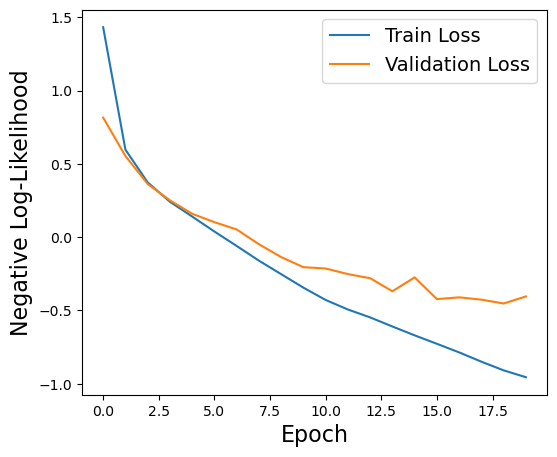

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Negative Log-Likelihood', fontsize=16)
ax.legend(fontsize=14)
plt.show()

## 3. Visualizing Posterior Samples with Corner Plots

Now that our model is trained, let's test it on some validation examples by sampling from the posterior $p(\theta|x)$ and visualizing the results with corner plots.

In [10]:
# Install corner for visualization if needed
try:
    import corner
    print("corner library is already installed.")
except ImportError:
    !pip install corner
    import corner
    print("corner library installed successfully.")

corner library is already installed.


In [11]:
def sample_single_obs(model, x_obs, norm_dict, n_samples=5000):
    """
    Sample from the posterior p(θ|x) for a given observation.

    Parameters:
    - model: trained NPE model
    - x_obs: tensor containing the observation x
    - norm_dict: dictionary containing normalization parameters
    - n_samples: number of samples to draw from the posterior
    Returns:
    - samples: numpy array of shape (n_samples, 2) containing samples from the posterior
    """
    model.eval()

    x_obs = torch.tensor(x_obs, dtype=torch.float32)
    x_obs = x_obs.reshape(1, -1)  # reshape to (1, input_dim)
    x_obs = (x_obs - norm_dict['X_loc']) / norm_dict['X_scale']

    with torch.no_grad():
        samples_normalized = model.sample(x_obs, n_samples)  # zuko syntax
        samples = samples_normalized.cpu().numpy().squeeze()
        samples = samples * norm_dict['y_scale'].numpy() + norm_dict['y_loc'].numpy()

    return samples

In [12]:
# Select a few test examples from validation set
n_test_examples = 3
test_indices = [9000, 9200, 9500]  # indices from validation set

# Prepare test data (same preprocessing as training data)
test_streams = streams_subsampled[test_indices]
test_params = np.vstack((np.log10(M_sh[test_indices]), vz_impact[test_indices])).T

print(f"Sampling posteriors for {n_test_examples} test examples...")

# Sample from posterior for each test example
posterior_samples = []
for i, idx in enumerate(test_indices):
    samples = sample_single_obs(simple_npe, test_streams[i], norm_dict, n_samples=10_000)
    posterior_samples.append(samples)
    print(f"- Example {i+1}: log10(M_sh)={test_params[i, 0]:.2f}, vz={test_params[i, 1]:.1f} km/s")

Sampling posteriors for 3 test examples...
- Example 1: log10(M_sh)=6.06, vz=22.9 km/s
- Example 2: log10(M_sh)=6.96, vz=31.6 km/s
- Example 3: log10(M_sh)=7.33, vz=-33.5 km/s


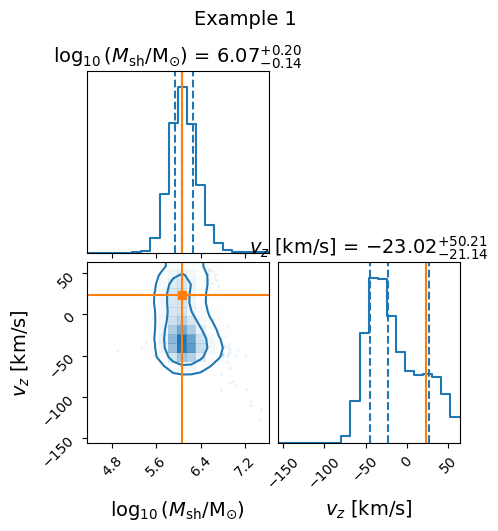

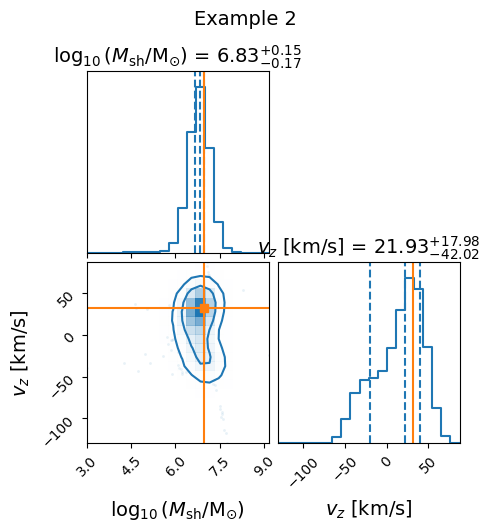

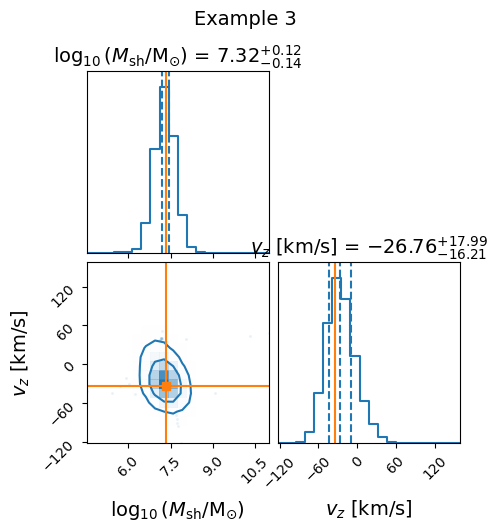

In [13]:
# Plot the posterior samples using corner
for i in range(n_test_examples):
    fig = plt.figure(figsize=(5, 5))
    fig = corner.corner(
        posterior_samples[i],
        labels=[r'$\log_{10}(M_\mathrm{sh}/\mathrm{M}_{\odot})$', r'$v_{z}$ [km/s]'],
        truths=test_params[i],
        show_titles=True,
        title_fmt='.2f',
        title_kwargs={"fontsize": 14},
        label_kwargs={"fontsize": 14},
        bins=20,
        levels=(0.68, 0.95),
        quantiles=[0.16, 0.5, 0.84],
        smooth=1.0,
        smooth1d=1.0,
        color='C0',
        truth_color='C1',
        fig=fig
    )
    fig.suptitle(f'Example {i+1}', fontsize=14, y=1.05)
    plt.show()

**Note on Flow Leakage:** When using normalizing flows, be cautious of flow leakage - a phenomenon where the flow assigns non-negligible probability mass to parameter regions outside the prior bounds. This can occur when:
- The flow's base distribution (usually Gaussian) has unbounded support while the prior is bounded
- Training data doesn't adequately sample the prior boundaries
- The flow architecture doesn't enforce hard constraints

Flow leakage naturally improves with more training samples, but can still be present in well-trained models. Always check that the posterior samples respect the prior bounds, and if not, simply reject samples outside the prior during inference.

## 4. Validation Tests

A major advantage of NPE is amortization: once trained, the model can infer posteriors for new observations without retraining. This allows us to perform extensive tests on the full validation tests to assess model performance.

We will perform two tests:
1. **Predicted vs True**: Plot the predicted posterior means against the true parameter values for all validation examples. This gives a quick visual check of bias and scatter.
2. **Coverage Tests**: Evaluate how well the predicted posteriors capture the true parameters using rank-based and TARP coverage tests.

In [14]:
def sample_posteriors(model, loader, norm_dict, n_samples=5000):
    """
    Sample from the posterior p(θ|x) from all observations in the DataLoader.
    Also return the true parameters for comparison.

    Parameters:
    - model: trained NPE model
    - loader: DataLoader containing the observation x
    - norm_dict: dictionary containing normalization parameters
    - n_samples: number of samples to draw from the posterior
    Returns:
    - samples: numpy array of shape (n_samples, 2) containing samples from the posterior
    - truths: numpy array of shape (n_samples, 2) containing the true parameters
    """
    model.eval()
    posteriors_list = []
    truths_list = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            context = model.embedding_network(x_batch)
            samples_normalized = model.flow(context).sample((n_samples, ))  # zuko syntax

            # zuko returns (n_samples, batch_size, output_dim)
            # we will reshape this to (batch_size, n_samples, output_dim) for easier processing
            samples_normalized = samples_normalized.permute(1, 0, 2)

            # Denormalize back to original parameter space
            samples = samples_normalized.cpu().numpy().squeeze()
            samples = samples * norm_dict['y_scale'].numpy() + norm_dict['y_loc'].numpy()
            posteriors_list.append(samples)

            truths = y_batch.cpu().numpy().squeeze()
            truths = truths * norm_dict['y_scale'].numpy() + norm_dict['y_loc'].numpy()
            truths_list.append(truths)

    posteriors_list = np.concatenate(posteriors_list, axis=0)
    truths_list = np.concatenate(truths_list, axis=0)

    return posteriors_list, truths_list

posterior_samples_all, truths_all = sample_posteriors(
    simple_npe, val_loader, norm_dict, n_samples=2000)

We will first plot the predicted vs true values for both parameters across all validation examples. Ideally, points should lie along the diagonal line, indicating accurate predictions.

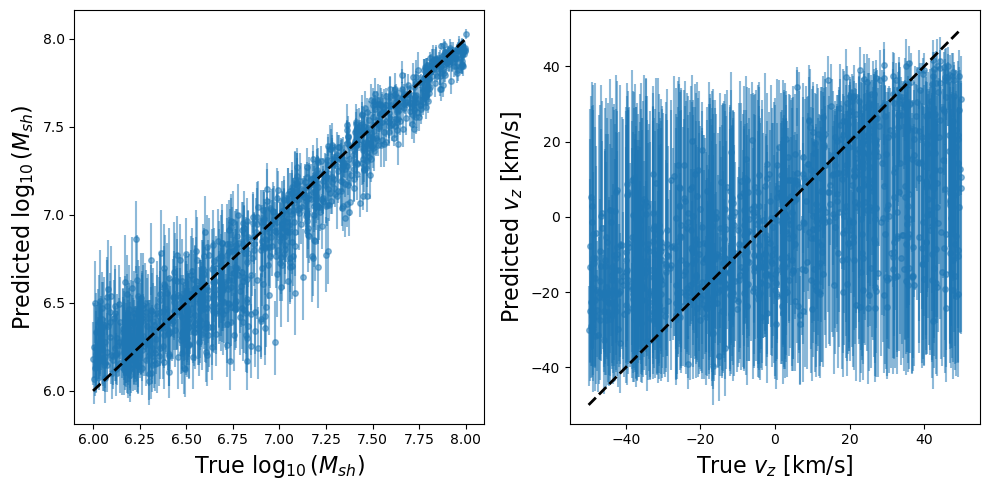

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Compute point estimates (median) and uncertainties (16th and 84th percentiles)
predicted_median, predicted_lower, predicted_upper = np.percentile(
    posterior_samples_all, [50, 16, 84], axis=1)

# True vs Predicted for log10(M_sh)
axes[0].errorbar(
    truths_all[:, 0],
    predicted_median[:, 0],
    yerr=[predicted_median[:, 0] - predicted_lower[:, 0],
          predicted_upper[:, 0] - predicted_median[:, 0]],
    fmt='o', markersize=4, alpha=0.5, label='Predictions',
    zorder=0
)
axes[0].plot([6, 8], [6, 8], 'k--', lw=2, zorder=1)
axes[0].set_xlabel(r'True $\log_{10}(M_{sh})$', fontsize=16)
axes[0].set_ylabel(r'Predicted $\log_{10}(M_{sh})$', fontsize=16)

# True vs Predicted for vz_impact
axes[1].errorbar(
    truths_all[:, 1],
    predicted_median[:, 1],
    yerr=[predicted_median[:, 1] - predicted_lower[:, 1],
          predicted_upper[:, 1] - predicted_median[:, 1]],
    fmt='o', markersize=4, alpha=0.5, label='Predictions',
    zorder=0
)
axes[1].plot([-50, 50], [-50, 50], 'k--', lw=2, zorder=1)
axes[1].set_xlabel(r'True $v_z$ [km/s]', fontsize=16)
axes[1].set_ylabel(r'Predicted $v_z$ [km/s]', fontsize=16)

plt.tight_layout()

Now let's validate our NPE model using the calibration tests from Tutorial 04:
- **Rank-based test**: Checks if marginal posteriors are well-calibrated
- **TARP**: Tests joint posterior calibration

In [16]:
from scipy.stats import kstest
from scipy import stats

# Install tarp for coverage tests if needed
try:
    import tarp
    print("tarp library is already installed.")
except ImportError:
    !pip install deprecation tarp
    import tarp
    print("tarp library installed successfully.")

tarp library is already installed.


### 4a. Rank-based Test
See Tutorial 04 for details on the rank-based calibration test. We'll apply it separately for each parameter, since this test only works for 1D marginals.

In [17]:
def rank_based_calibration(theta_true, theta_samples):
    """
    Compute ranks for the rank-based calibration test.

    Parameters:
    - theta_true: (n_tests,) array of true parameter values
    - theta_samples: (n_tests, n_samples) array of posterior samples

    Returns:
    - ranks: (n_tests,) array of ranks (normalized to [0, 1])
    """
    n_tests, n_samples = theta_samples.shape

    # For each test case, count how many samples are less than the true value
    ranks = np.sum(theta_samples < theta_true.reshape(-1, 1), axis=1)

    # Normalize ranks to [0, 1]
    normalized_ranks = ranks / n_samples

    return normalized_ranks

# Compute ranks for each parameter separately
ranks_log_mass = rank_based_calibration(truths_all[:, 0], posterior_samples_all[:, :, 0])
ranks_vz = rank_based_calibration(truths_all[:, 1], posterior_samples_all[:, :, 1])

print("Rank-based Calibration Statistics:")
print(f"\nlog10(M_sh):")
print(f"  Mean: {ranks_log_mass.mean():.3f} (expected: 0.500)")
print(f"  Std:  {ranks_log_mass.std():.3f} (expected: {1/np.sqrt(12):.3f})")
print(f"\nvz:")
print(f"  Mean: {ranks_vz.mean():.3f} (expected: 0.500)")
print(f"  Std:  {ranks_vz.std():.3f} (expected: {1/np.sqrt(12):.3f})")

Rank-based Calibration Statistics:

log10(M_sh):
  Mean: 0.556 (expected: 0.500)
  Std:  0.301 (expected: 0.289)

vz:
  Mean: 0.523 (expected: 0.500)
  Std:  0.295 (expected: 0.289)


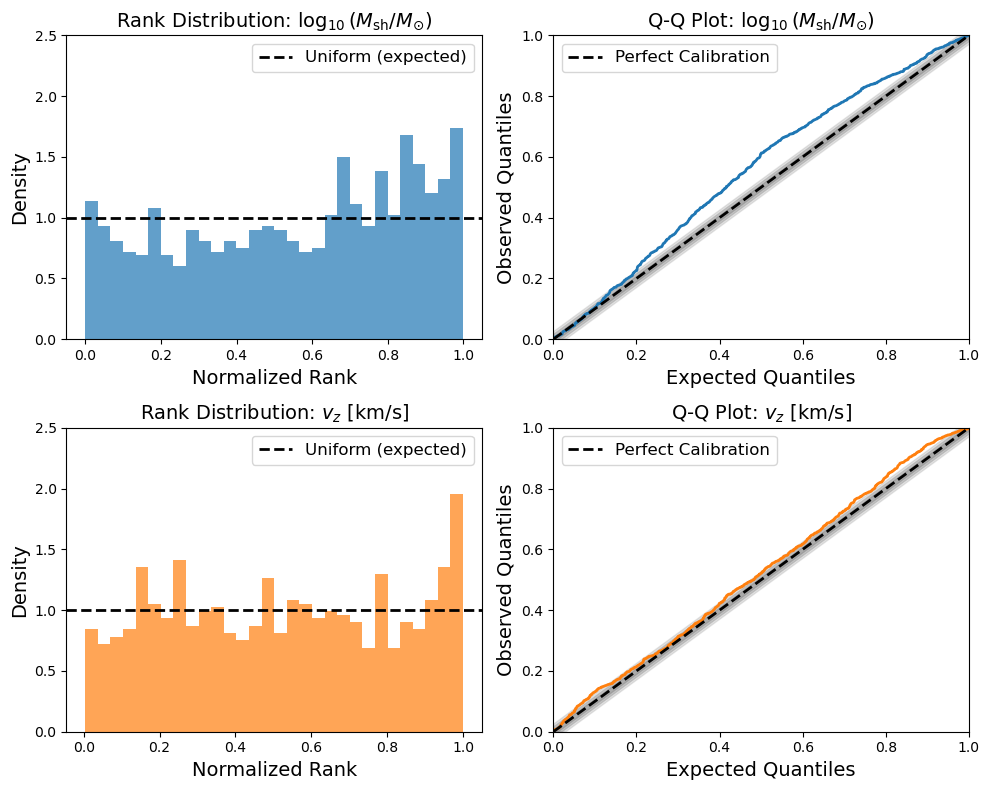

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

param_names = [r'$\log_{10}(M_{\rm sh}/M_{\odot})$', r'$v_z$ [km/s]']
all_ranks = [ranks_log_mass, ranks_vz]

for param_idx, (ranks, param_name) in enumerate(zip(all_ranks, param_names)):
    # Histogram
    ax = axes[param_idx, 0]
    ax.hist(ranks, bins=30, color=f'C{param_idx}', density=True, alpha=0.7)
    ax.axhline(1.0, color='black', linestyle='--', linewidth=2, label='Uniform (expected)')
    ax.set_xlabel('Normalized Rank', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_title(f'Rank Distribution: {param_name}', fontsize=14)
    ax.legend(fontsize=12)
    ax.set_ylim([0, 2.5])

    # Q-Q plot
    ax = axes[param_idx, 1]
    sorted_ranks = np.sort(ranks)
    theoretical_quantiles = np.linspace(0, 1, len(sorted_ranks))
    ax.plot(theoretical_quantiles, sorted_ranks, '-', lw=2, color=f'C{param_idx}')
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)

    # Confidence bands (1, 2, 3 sigma)
    n = len(ranks)
    se = 1 / np.sqrt(12 * n)
    sigmas = [1, 2, 3]
    alphas = [0.4, 0.3, 0.2]
    quantiles = np.linspace(0, 1, 100)
    for sigma, alpha_val in zip(sigmas, alphas):
        lower_band = np.maximum(quantiles - sigma * se, 0)
        upper_band = np.minimum(quantiles + sigma * se, 1)
        ax.fill_between(quantiles, lower_band, upper_band, alpha=alpha_val, color='gray')

    ax.legend(fontsize=12)
    ax.set_xlabel('Expected Quantiles', fontsize=14)
    ax.set_ylabel('Observed Quantiles', fontsize=14)
    ax.set_title(f'Q-Q Plot: {param_name}', fontsize=14)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

In [19]:
# Perform Kolmogorov-Smirnov test
ks_stat_mass, p_value_mass = kstest(ranks_log_mass, 'uniform')
ks_stat_vz, p_value_vz = kstest(ranks_vz, 'uniform')

print(f"""Kolmogorov-Smirnov Test Results
(Tests if ranks are uniformly distributed)

log10(M_sh):
  KS statistic: {ks_stat_mass:.4f}
  p-value: {p_value_mass:.4f}
  {'✓ Well calibrated' if p_value_mass > 0.05 else '✗ Poor calibration'}

vz:
  KS statistic: {ks_stat_vz:.4f}
  p-value: {p_value_vz:.4f}
  {'✓ Well calibrated' if p_value_vz > 0.05 else '✗ Poor calibration'}

Note: p-value > 0.05 suggests good calibration
""")

Kolmogorov-Smirnov Test Results
(Tests if ranks are uniformly distributed)

log10(M_sh):
  KS statistic: 0.1130
  p-value: 0.0000
  ✗ Poor calibration

vz:
  KS statistic: 0.0500
  p-value: 0.0130
  ✗ Poor calibration

Note: p-value > 0.05 suggests good calibration



### 4b. TARP Calibration Test

See Tutorial 04 for details on TARP ([Lemos et al. 2023](https://arxiv.org/abs/2302.03026)). Unlike the rank-based test, TARP can detect miscalibration in the joint posterior distribution.

In [20]:
# Apply TARP coverage test
print("Running TARP coverage test...")
print("This may take a minute...\n")

# TARP expects shape: (n_samples, n_tests, n_params)
# We have: (n_tests, n_samples, n_params)
# So we need to transpose the first two dimensions
tarp_samples = np.transpose(posterior_samples_all, (1, 0, 2))

ecp, alpha = tarp.get_tarp_coverage(
    tarp_samples,  # shape: (n_samples, n_tests, n_params)
    truths_all,    # shape: (n_tests, n_params)
    bootstrap=True,
    num_bootstrap=100
)

print("✓ TARP test complete!")

Running TARP coverage test...
This may take a minute...



100%|██████████| 100/100 [00:02<00:00, 39.36it/s]

✓ TARP test complete!


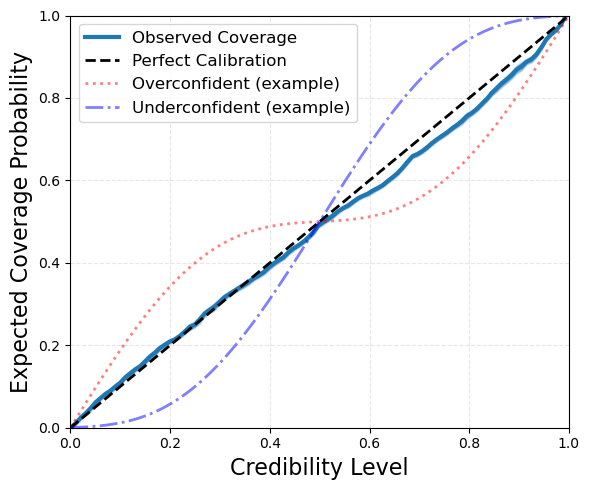

In [21]:
# Plot TARP Expected Coverage Probability (ECP) curve
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Plot the mean ECP curve
ax.plot(alpha, ecp.mean(axis=0), label='Observed Coverage', color='C0', linewidth=3)
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)

# Plot confidence bands (1, 2, 3 sigma) from bootstrap
sigmas = [1, 2, 3]
alphas_fill = [0.4, 0.3, 0.2]
for k, alpha_val in zip(sigmas, alphas_fill):
    ax.fill_between(
        alpha,
        ecp.mean(axis=0) - k * ecp.std(axis=0),
        ecp.mean(axis=0) + k * ecp.std(axis=0),
        color='C0', alpha=alpha_val,
    )

# Add reference curves for over/under-confident
x_region = np.linspace(0, 1, 100)
overconfident_curve = x_region + 0.15 * np.sin(2 * np.pi * x_region)
underconfident_curve = x_region - 0.15 * np.sin(2 * np.pi * x_region)
ax.plot(x_region, overconfident_curve, color='red', ls='dotted',
        linewidth=2, alpha=0.5, label='Overconfident (example)')
ax.plot(x_region, underconfident_curve, color='blue', ls='dashdot',
        linewidth=2, alpha=0.5, label='Underconfident (example)')

ax.set_xlabel('Credibility Level', fontsize=16)
ax.set_ylabel('Expected Coverage Probability', fontsize=16)
ax.legend(fontsize=12, loc='upper left')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

## Summary and Key Takeaways

In this tutorial, we successfully implemented and validated an NPE model for inferring subhalo properties from stellar stream data. Here are the key takeaways:

- **Model architecture**: we use a simple MLP embedding + Neural Spline Flow to model the posterior distribution. The embedding network compresses high-dimensional stream data into a low-dimensional representation, which the flow uses to learn the conditional posterior.
- **Validation test**:
  - We plot the median posterior predictions against the true parameters to visually assess bias and scatter.
  - We perform rank-based and TARP coverage tests to quantitatively evaluate posterior calibration.
- We find that the SimpleNPE model does not provide a good constraint on the parameters and also does not pass the coverage test. This can suggest that:
  - The model does is not expressive enough to capture the complex relationships in the data
  - The number of training samples is insufficient for the model to learn accurate posteriors

In this next tutorial, we will explore more advanced architectures that may improve performance.